
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
# plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.metrics import adjusted_rand_score, precision_recall_fscore_support

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

Определим число уникальных значений меток целевого класса.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

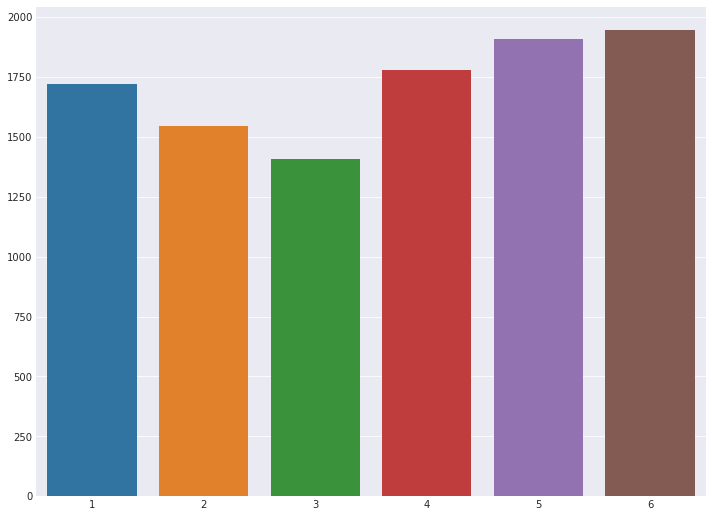

In [6]:
val, counts = np.unique(y, return_counts = True)
sns.barplot(y = counts, x = val)

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
# Ваш код здесь
pca = PCA(n_components = 2, random_state = RANDOM_STATE)
X_pca = pca.fit_transform(X)

In [10]:
pca.explained_variance_ratio_

array([0.62227069, 0.04772595])

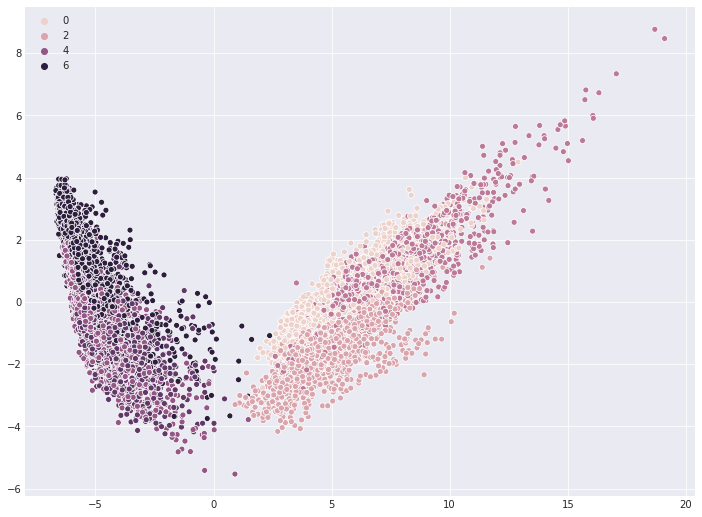

In [11]:
sns.scatterplot(x = X_pca[: , 0], y = X_pca[: , 1], hue = y)

In [78]:
%%time
tsne = TSNE(n_components = 2, random_state = RANDOM_STATE)
x_tsne = tsne.fit_transform(X)

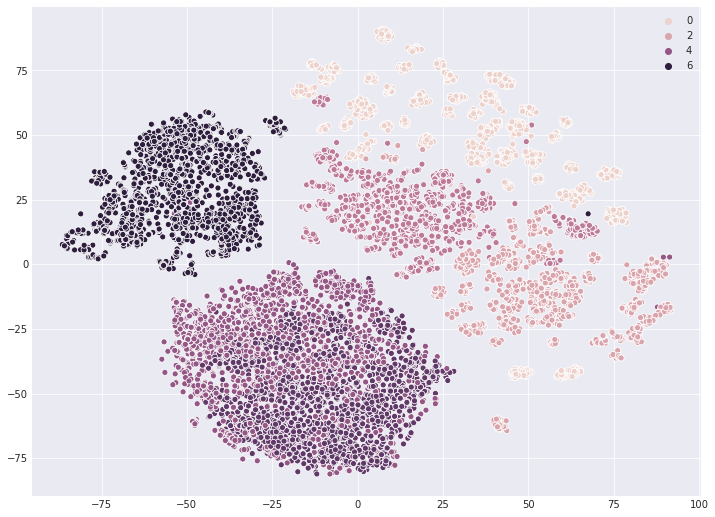

In [79]:
sns.scatterplot(x = x_tsne[: , 0], y = x_tsne[: , 1], hue = y)

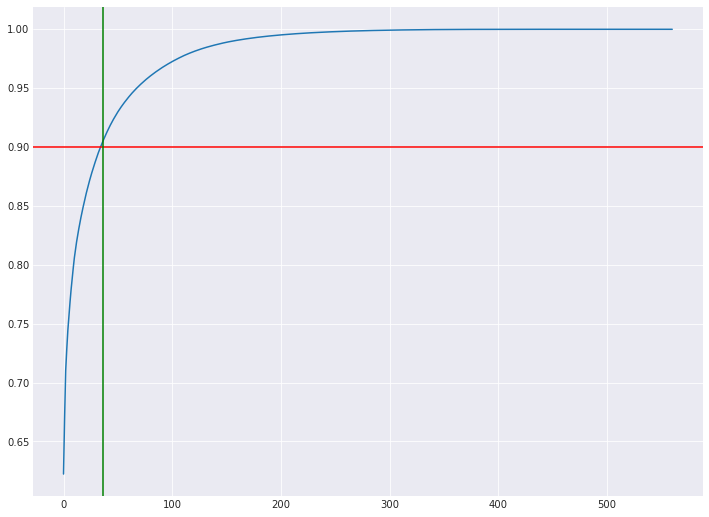

In [12]:
full_pca = PCA().fit(X)
plt = sns.lineplot(data = np.cumsum(full_pca.explained_variance_ratio_))
plt.axhline(0.9, color = 'r')
plt.axvline(36, color = 'g')

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [13]:
# Ваш код здесь

MIN_DISPERSION = 0.9

dispersion = 0
for i, dis_component in enumerate(full_pca.explained_variance_ratio_):
    dispersion += dis_component
    if dispersion >= MIN_DISPERSION:
        break

print(f'Мінімальна кількість головних компонент: {i+1}')
    

Мінімальна кількість головних компонент: 36


**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [14]:
# Ваш код здесь
round(full_pca.explained_variance_ratio_[0] * 100)

62.0

Визуализируйте данные в проекции на первые две главные компоненты.

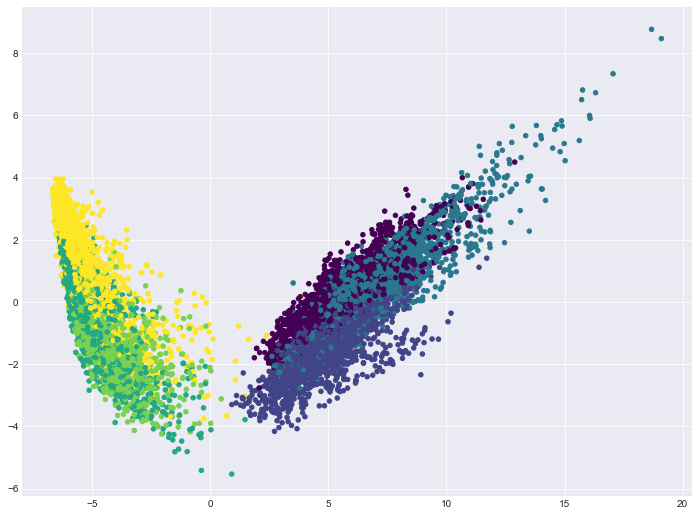

In [18]:
# Ваш код здесь
plt.scatter(x = X_pca[:, 0], y = X_pca[:, 1], c=y, s=20, cmap='viridis')

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) (ВІДПОВІДЬ)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

ВІДПОВІДЬ: (2 варіант), ми бачимо 2 кластери які поділені на "спокійні" (стояння, сидіння, лежання) стани та "активні" (ходіння, ходіння по сходах) стани

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [19]:
# Ваш код здесь
kmeans = KMeans(n_clusters = n_classes, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)
cluster_labels = kmeans.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

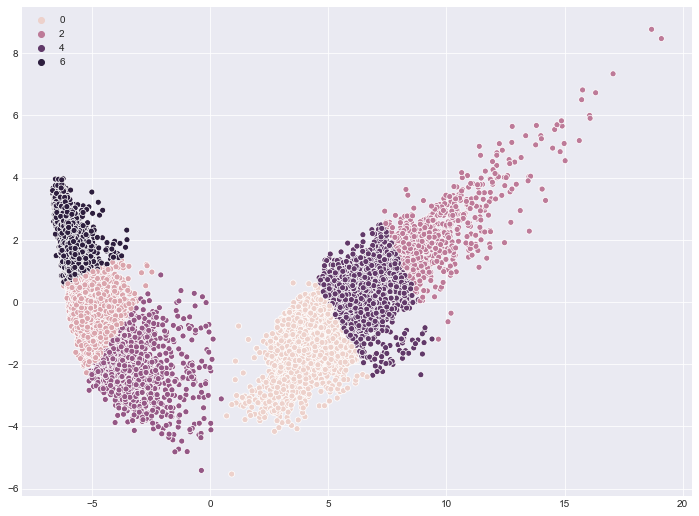

In [20]:
# Ваш код здесь
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], hue=cluster_labels)

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [21]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,666,0,192,0,864,0,1722
подъем вверх по лестнице,1071,0,38,0,435,0,1544
спуск по лестнице,188,0,522,0,696,0,1406
сидение,3,906,0,337,0,531,1777
стояние,0,1112,0,575,0,219,1906
лежание,12,547,0,169,0,1216,1944
все,1940,2565,752,1081,1995,1966,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [22]:
for i in range(len(tab.index)):
    val = tab.iloc[i, :-1].max() / tab.iloc[i].max()
    print(f"{tab.index[i]} -- {val}")

ходьба -- 0.5017421602787456
подъем вверх по лестнице -- 0.6936528497409327
спуск по лестнице -- 0.4950213371266003
сидение -- 0.509848058525605
стояние -- 0.583420776495278
лежание -- 0.6255144032921811
все -- 0.24905330614622778


ВІДПОВІДЬ: найкраще відокремилися "подъем вверх по лестнице"

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [23]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters = k, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)
    inertia.append(kmeans.inertia_)

<ipython-input-23-d15b01322af0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


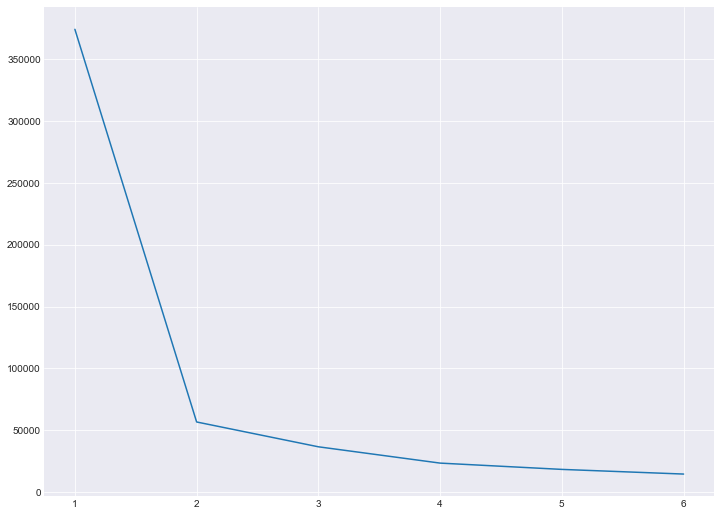

In [24]:
sns.lineplot(y = inertia, x = range(1, k + 1))

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2 (ВІДПОВІДЬ)
- 3
- 4

ВІДПОВІДЬ: (2 варіант), очевидно, як і візуально відображалося, що найбільш "інтуїтивно" поділити на 2 кластери

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [25]:
ag = AgglomerativeClustering(n_clusters = n_classes, 
                             linkage = 'ward').fit(X_pca)

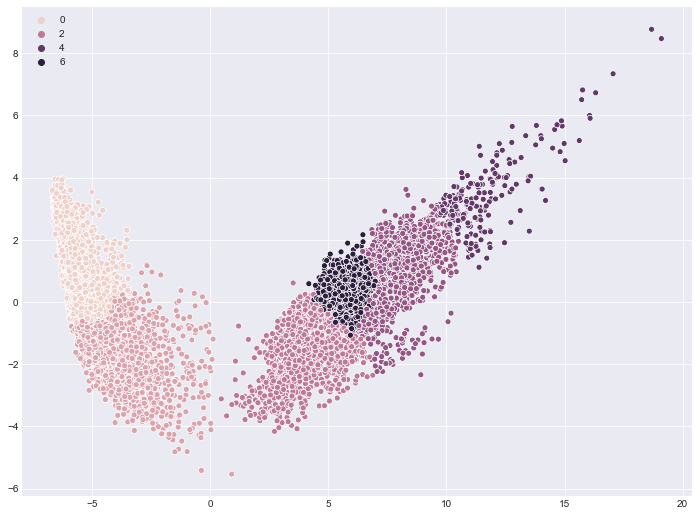

In [26]:
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], hue=ag.labels_)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [27]:
# Ваш код здесь
kmeans = KMeans(n_clusters = 2, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)

print(f"KMeand: {adjusted_rand_score(y, kmeans.labels_)}")
print(f"Agglomerative clustering: {adjusted_rand_score(y, ag.labels_)}")

KMeand: 0.33056464442967726
Agglomerative clustering: 0.3125825837921333


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

ВІДПОВІДЬ:
2 та 3 твердження правдиві

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [28]:
# Ваш код здесь
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [30]:
# Ваш код здесь
grid_svc = GridSearchCV(svc, param_grid = svc_params, n_jobs = -1, cv = 3).fit(X_train_scaled, y_train)
best_svc = grid_svc.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [101]:
grid_svc.best_score_

0.8853403719709018

In [31]:
# Ваш код здесь
best_svc.score(X_test_scaled, y_test)

0.9623345775364778

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1 (ВІДПОВІДЬ)
- 1
- 10

In [32]:
grid_svc.best_params_

{'C': 0.1}

In [33]:
y_predicted = best_svc.predict(X_test_scaled)

In [34]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение (ВІДПОВІДЬ)

In [61]:
scores = precision_recall_fscore_support(y_test, y_predicted)
precision_recall_fscore_table = pd.DataFrame(
                                            data = scores,
                                            index = ['precision', 'recall', 'fbeta_score', 'support'],
                                            columns = tab.index[:-1])
precision_recall_fscore_table

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание
precision,0.972441,0.980769,1.000000,0.963801,0.877759,1.000000
recall,0.995968,0.974522,0.985714,0.867617,0.971805,0.979516
fbeta_score,0.984064,0.977636,0.992806,0.913183,0.922391,0.989652
support,496.000000,471.000000,420.000000,491.000000,532.000000,537.000000


ВІДПОВІДЬ: (4 варіант)

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [102]:
pca = PCA(n_components = 36, random_state = RANDOM_STATE).fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state = RANDOM_STATE)
params = {'C': [0.001, 0.01, 0.1, 1, 10]}


grid_svc = GridSearchCV(svc, params, n_jobs = -1, cv = 3).fit(X_train_scaled_pca, y_train)
svc_best = grid_svc.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [103]:
grid_svc.best_params_

{'C': 1}

In [104]:
grid_svc.best_score_

0.887108357827015

In [105]:
svc_best.score(X_test_scaled_pca, y_test)

0.9046487953851374

ВІДПОВІДЬ: якщо говорити про "best_score_", то в обох випадках він майже однаковий. Якщо розрахувати score для тестових даних, то у другому випадку (для зменшеної розмірності) він гірше на 6%

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность (TRUE)
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком